In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import importlib

from tqdm import tqdm_notebook

In [2]:
try: importlib.reload(msp)
except: import ModSimPy as msp  # Библиотека с github - предназначена для имит. моделирования

# Helpful functions

In [3]:
type_priority_mapping = {k:v for k,v in zip(['gold','silver','regular'],range(1,4))}
type_salary_mapping = {k:v for k,v in zip(['gold','silver','regular'], [600*8, 500*8, 400*8])}

In [4]:
def to_next_timestep(system, state, tqdm):
    """
    Переводит систему в следующий момент времени
    """
    state['time_cur'] += system['timedelta']
    tqdm.update(system['timedelta'].seconds)

In [5]:
def calc_statistic(state):
    """
    Требуемая от симуляции статистика
    """
    data = pd.Series({        },
        name=state['time_cur'])
    return data

In [6]:
def get_datetime(hours, mins, secs=None):
    return datetime.datetime(2018,1,1,hours,mins, secs if secs else 0)

In [7]:
def get_panel(system, state):
    ds = pd.merge(state['connections_ds'], state['clients_ds'],
              left_on='client_id', right_on='id', suffixes=['_con','_client'], how='right').drop('client_id',axis=1)
    ds = pd.merge(ds, system['operators_ds'],
                  left_on='operator_id', right_on='id', suffixes=['','_operator'], how='left').drop('id',axis=1)
    ds = pd.merge(ds, state['queue_ds'],
                  left_on='id_client', right_on='client_id', suffixes=['','_queue'], how='left').drop('client_id',axis=1)
    ds = ds.rename(columns={'id_con':'id_connection', 'operator_id':'id_operator','line_id':'id_line',
                            'closed':'connection_closed',
                            'type':'type_client', 'opeartor_type':'type_operator',
                            'time_start':'time_start_connection',
                            'call_start_time':'time_start_call',
                            'max_waiting_time':'client_max_waiting_time',
                            'missed':'client_missed',
                            'start_work_time':'operator_start_work_time',
                            'priority':'client_priority',
                            'time_from':'time_quque_from',
                            'exit':'queue_exit'
                           })
    ds['hour'] = [x.hour for x in ds['time_start_call']]
    ds['client_missed'] = ds['client_missed'].astype(int)
    return ds

In [8]:
def get_line_loads(panel_ds, time_from=get_datetime(7,0), time_to=get_datetime(19,0)):
    all_time = pd.DataFrame(pd.date_range(time_from, time_to, freq='s'), columns=['ctime'])[:-1]
    all_time.index = all_time['ctime']
    tts = []
    for idx, row in panel_ds.iterrows():
        tt = all_time.loc[row['time_start_connection']:row['time_start_connection']+row['time_to_service']][:-1]
        for f in ['id_connection', 'id_line', 'id_client', 'id_operator']:
            tt[f] = row[f]
        tts.append(tt)
    line_loads_ds = pd.concat(tts)
    del tts
    line_loads_ds = pd.merge(all_time, line_loads_ds, on='ctime', how='left')
    line_loads_ds = line_loads_ds.fillna(-1)
    line_loads_ds = line_loads_ds.pivot_table(index='ctime', columns='id_line', values='id_connection')
    line_loads_ds = line_loads_ds.drop(-1,axis=1)
    #line_loads_ds = line_loads_ds.fillna(-1)
    return line_loads_ds

In [9]:
def add_operator(type_, start_work_time, ds):
    ds.loc[len(ds)] = {'id':len(operators_ds), 'type':type_,
                       'priority':type_priority_mapping[type_], 'start_work_time':start_work_time}
def add_operators(ar, ds):
    for t, swt in ar: add_operator(t, swt, ds)

# Подготовка данных

Заданные значения частот звонков разных клиентов

In [10]:
calls_stat_ds = pd.DataFrame()
calls_stat_ds['regular_clients'] = [87, 165, 236, 323, 277, 440, 269, 342, 175, 273, 115,  56]
calls_stat_ds['vip_clients'] = [89, 243, 221, 180, 301, 490, 394, 347, 240, 269, 145,  69]
calls_stat_ds['silver_clients'] = 0.68*calls_stat_ds['vip_clients']
calls_stat_ds['gold_clients'] = calls_stat_ds['vip_clients']-calls_stat_ds['silver_clients']
for f in calls_stat_ds.columns:
    calls_stat_ds[f+'_per_sec'] = calls_stat_ds[f]/3600
calls_stat_ds.index = range(7,19)
print('Частота звонков')
calls_stat_ds

Частота звонков


,regular_clients,vip_clients,silver_clients,gold_clients,regular_clients_per_sec,vip_clients_per_sec,silver_clients_per_sec,gold_clients_per_sec
7,87,89,60.52,28.48,0.024167,0.024722,0.016811,0.007911
8,165,243,165.24,77.76,0.045833,0.067500,0.045900,0.021600
9,236,221,150.28,70.72,0.065556,0.061389,0.041744,0.019644
10,323,180,122.40,57.60,0.089722,0.050000,0.034000,0.016000
11,277,301,204.68,96.32,0.076944,0.083611,0.056856,0.026756
12,440,490,333.20,156.80,0.122222,0.136111,0.092556,0.043556
13,269,394,267.92,126.08,0.074722,0.109444,0.074422,0.035022
14,342,347,235.96,111.04,0.095000,0.096389,0.065544,0.030844
15,175,240,163.20,76.80,0.048611,0.066667,0.045333,0.021333
16,273,269,182.92,86.08,0.075833,0.074722,0.050811,0.023911


In [11]:
operators_ds = pd.DataFrame(columns=['id', 'type', 'priority','start_work_time'])
for f in ['id','priority']:
    operators_ds[f] = operators_ds[f].astype(int)

add_operators([['regular', get_datetime(7,0)],
               ['regular', get_datetime(11,0)],
               ['silver',  get_datetime(7,0)],
               ['gold',    get_datetime(8,0)]],
             operators_ds)

# Модель 1

In [12]:
def init_state(system):
    """
    Задаёт первичное состояние системы
    """
    state = {
        'time_cur': system['time_start'],  # Текущее время
        # Данные по всем клиентам
        'clients_ds': pd.DataFrame(columns=['id','type','call_start_time', 'max_waiting_time', 'missed']),
        # Данные по всем соединениям операторов с клиентами
        'connections_ds': pd.DataFrame(columns=['id', 'operator_id', 'client_id', 'line_id', 'time_start','time_to_service', 'closed']),
        # Очередь клиентов на соединение
        'queue_ds': pd.DataFrame(columns=['client_id','priority', 'time_from', 'blocked', 'exit']),  # 
        # Клиенты, которые в очереди, но ждут оценки времени, или вводят номера карт
        'blocked_ds': pd.DataFrame(columns=['client_id','type','time_from','time_to', 'unblocked'])
    }
    state['free_lines'] = list(range(system['n_lines']))
    state['free_operators'] =  {t:[] for t in ['regular','silver','gold']}
    state['blocked_clients'] = {t:[] for t in ['regular','silver','gold']}
    state['waiting_clients'] = {t:[] for t in ['regular','silver','gold']}
    
    for ds, f in [['clients_ds', 'id'],
                  ['clients_ds','max_waiting_time'],
                  ['connections_ds', 'id'],
                  ['connections_ds', 'operator_id'],
                  ['connections_ds', 'client_id'],
                  ['connections_ds', 'line_id'],
                  ['queue_ds', 'priority'],
                  ['blocked_ds','client_id']]:
        state[ds][f] = state[ds][f].astype(int)
    return state

In [13]:
def generate_clients(system, state):
    """
    Генератор клиентов. Использует заданные частоты звонков клиентов.
    За одну секунду генерируется несколько клиентов, т.к. могут позвонить одновременно золотой и обычные клиент.
    """
    probs = [system['calls_stat'].loc[state['time_cur'].hour, f'{t}_clients_per_sec'] for t in system['client_types']]
    bools = [msp.flip(p) for p in probs]  # Перевод вероятности в True/False
    clients = [ctype for ctype, b in zip(system['client_types'], bools) if b] 
    ids = []
    for ctype in clients:
        data = {'id':len(state['clients_ds']),
                'type':ctype,
                'call_start_time':state['time_cur'],
                'max_waiting_time':300,  # seconds  # временная константа 
                'missed':False}  # повесил-ли клиент трубку
        ids.append(data['id'])
        state['clients_ds'].loc[data['id']] = data
    return ids

In [14]:
def add_clients_to_queue(state, clients_ids):
    """
    Добавление клиентов с заданными id в очередь ожидания
    """
    for cid in clients_ids:
        data = {'client_id':cid,
                'priority': type_priority_mapping[state['clients_ds'].at[cid,'type']],
                'time_from':state['time_cur'],
                'blocked':False,
                'exit':False}
        state['queue_ds'] = state['queue_ds'].append(data, ignore_index=True)
        state['waiting_clients'][state['clients_ds'].at[cid,'type']].append(cid)

In [15]:
def drop_clients_from_queue(state):
    """
    Моделирование "бросания трубки" недождавшихся клиентов
    """
    cds = pd.merge(state['queue_ds'], state['clients_ds'], left_on='client_id',right_on='id', how='right')
    
    missed = cds[cds['exit']==False]
    missed = missed.loc[([x.seconds for x in state['time_cur']-missed['time_from']]>missed['max_waiting_time'])]
    missed_cids = missed['client_id']
    if len(missed_cids)>0:
        # Убираем клиента из очереди
        state['queue_ds'].loc[state['queue_ds']['client_id'].isin(missed_cids), 'exit'] = True
        # Запись, что клиент бросил трубку
        state['clients_ds'].loc[state['clients_ds']['id'].isin(missed_cids), 'missed'] = True
        # Удаление клиента из очереди, оптимизирующей расчёты
        for i in missed_cids:
            state['waiting_clients'][state['clients_ds'].at[i, 'type']].remove(i)

In [16]:
def block_clients_in_queue(state):
    cds = state['queue_ds'][state['queue_ds']['priority']==3]
    cds = cds[cds['exit']==False]
    cds = cds[(state['time_cur']-cds['time_from'])==datetime.timedelta(seconds=1)]
    state['queue_ds'].loc[cds['client_id'], 'blocked'] = True
    for i in cds['client_id']:
        if i in state['waiting_clients']['regular']:
            state['waiting_clients']['regular'].remove(i)
    
    cds = state['queue_ds'][state['queue_ds']['priority']<3]
    cds = cds[cds['exit']==False]
    cds = cds[cds['time_from']==state['time_cur']]
    state['queue_ds'].loc[cds['client_id'], 'blocked'] = True
    for i in cds['client_id']:
        if i in state['waiting_clients']['silver']:
            state['waiting_clients']['silver'].remove(i)
        if i in state['waiting_clients']['gold']:
            state['waiting_clients']['gold'].remove(i)

In [17]:
def generate_operators(system, state):
    if state['time_cur'].minute==0 and state['time_cur'].second==0:
        new_operators = system['operators_ds'][system['operators_ds']['start_work_time']==state['time_cur']]
        for idx, row in new_operators.iterrows():
            state['free_operators'][row['type']].append(row['id'])

In [18]:
def drop_operators(system, state):
    for t, ids in state['free_operators'].items():
        operators = system['operators_ds'].loc[ids]
        operators = operators[operators['start_work_time']+system['operators_work_duration']<=state['time_cur']]
        for i in operators['id']:
            state['free_operators'][t].remove(i)

In [19]:
def occupy_operators(system, state):
    """
    Поиск свободных операторов, линий и клиентов в очереди. Установка соединений
    """
    for type_op in ['regular','silver','gold']:
        ids_op = state['free_operators'][type_op]
        if len(ids_op)==0: continue
        if len(state['free_lines'])==0: break
        clients_available = state['waiting_clients']['regular']
        for t in ['silver', 'gold']:
            if type_op == t:
                clients_available = state['waiting_clients'][t]+clients_available
        if len(clients_available)==0: continue
            
        op_cl_pairs = list(zip(ids_op, clients_available))
        for op_id, cl_id in op_cl_pairs:
            for t in ['regular','silver','gold']:
                if cl_id in state['waiting_clients'][t]:
                    state['waiting_clients'][t].pop(0)
            state['free_operators'][type_op].pop(0)
            l_id = state['free_lines'].pop(0)
            data = {
                'id': len(state['connections_ds']),
                'operator_id':op_id,
                'client_id':cl_id,
                'line_id':l_id,
                'time_start':state['time_cur'],
                'time_to_service': datetime.timedelta(seconds=600),
                'closed':False,
                }
            state['connections_ds'] = state['connections_ds'].append(data, ignore_index=True)
            state['queue_ds'].at[cl_id,'exit'] = True 
    return

In [20]:
def release_operators(system, state):
    """
    Закрытие соединений, в которых оператор уже всё отработал
    """
    cds = state['connections_ds'][state['connections_ds']['closed']==False]
    ended_connections = cds[(state['time_cur']-cds['time_start'])>cds['time_to_service']]
    state['connections_ds'].loc[ended_connections.index, 'closed'] = True
    for idx, row in ended_connections.iterrows():
        state['free_operators'][system['operators_ds'].at[row['operator_id'],'type']].append(row['operator_id'])
        state['free_lines'].append(row['line_id'])
    state['free_lines'] = sorted(state['free_lines'])
    return ended_connections

In [21]:
def step(system, state):        
    """
    Один временной шаг системы
    """
    new_clients_id = generate_clients(system, state)
    add_clients_to_queue(state, new_clients_id)
    #block_clients_in_queue(state)
    
    #print('{regular} {silver} {gold}'.format(**{k:state.free_operators[k] for k in['regular','silver','gold']}))
    generate_operators(system, state)
    drop_operators(system, state)   
    
    occupy_operators(system, state)
    release_operators(system, state)
    
    drop_clients_from_queue(state)

In [22]:
def run_simulation(system):
    """
    Внешняя функция для запуска системы
    """
    state = init_state(system)
    
    results_frame = msp.TimeFrame()
    
    # tqdm - библиотека для рисования прогрессбаров
    tqdm = tqdm_notebook(total=(system['time_end']-system['time_start']).seconds//system['timedelta'].seconds)
    while state['time_cur']<system['time_end']:
        try:
            step(system, state)
        except Exception as e:
            print(e)
            return results_frame, state
        results_frame = results_frame.append(calc_statistic(state))
        to_next_timestep(system, state, tqdm)
    tqdm.close()

    return results_frame, state

In [23]:
system =  {'time_start': get_datetime(7,0),
            #'time_end': get_datetime(19,0),
            'time_end': get_datetime(8,0),
            'timedelta': datetime.timedelta(seconds=1),
            'n_lines': 50,  # кол-во линий связи
            'calls_stat': calls_stat_ds,  # частоты звонков
            'time_to_serve': 120,  # seconds # временная константа. время обслуживания каждого клиента
            'client_types': ['regular', 'silver', 'gold'],  # типы клиентов. затем добавятся silver и gold
            'operators_ds': operators_ds,
            'operators_work_duration': datetime.timedelta(hours=8),
            'n_lines_vip': 5
         }

In [24]:
results, state_final = run_simulation(system)

A Jupyter Widget

In [25]:
state_final['waiting_clients']

{'gold': [157, 159], 'regular': [161, 162], 'silver': [158, 160, 163]}

In [26]:
ds = get_panel(system, state_final)
ds.head()

,id_connection,id_operator,id_line,time_start_connection,time_to_service,connection_closed,id_client,type_client,time_start_call,client_max_waiting_time,client_missed,type_operator,client_priority,operator_start_work_time,priority_queue,time_quque_from,blocked,queue_exit,hour
0,0.0,2,0.0,2018-01-01 07:00:27,00:10:00,True,1,silver,2018-01-01 07:00:27,300,0,silver,2.0,2018-01-01 07:00:00,2,2018-01-01 07:00:27,False,True,7
1,1.0,0,1.0,2018-01-01 07:01:31,00:10:00,True,3,regular,2018-01-01 07:01:31,300,0,regular,3.0,2018-01-01 07:00:00,3,2018-01-01 07:01:31,False,True,7
2,2.0,2,0.0,2018-01-01 07:10:29,00:10:00,True,22,silver,2018-01-01 07:07:08,300,0,silver,2.0,2018-01-01 07:00:00,2,2018-01-01 07:07:08,False,True,7
3,3.0,0,1.0,2018-01-01 07:11:33,00:10:00,True,19,regular,2018-01-01 07:06:37,300,0,regular,3.0,2018-01-01 07:00:00,3,2018-01-01 07:06:37,False,True,7
4,4.0,2,0.0,2018-01-01 07:20:31,00:10:00,True,51,silver,2018-01-01 07:17:42,300,0,silver,2.0,2018-01-01 07:00:00,2,2018-01-01 07:17:42,False,True,7


In [27]:
ds.sort_values('time_start_call')

,id_connection,id_operator,id_line,time_start_connection,time_to_service,connection_closed,id_client,type_client,time_start_call,client_max_waiting_time,client_missed,type_operator,client_priority,operator_start_work_time,priority_queue,time_quque_from,blocked,queue_exit,hour
12,NaN,NaN,NaN,NaT,NaT,NaN,0,gold,2018-01-01 07:00:26,300,1,NaN,NaN,NaT,1,2018-01-01 07:00:26,False,True,7
0,0.0,2,0.0,2018-01-01 07:00:27,00:10:00,True,1,silver,2018-01-01 07:00:27,300,0,silver,2.0,2018-01-01 07:00:00,2,2018-01-01 07:00:27,False,True,7
13,NaN,NaN,NaN,NaT,NaT,NaN,2,gold,2018-01-01 07:01:06,300,1,NaN,NaN,NaT,1,2018-01-01 07:01:06,False,True,7
1,1.0,0,1.0,2018-01-01 07:01:31,00:10:00,True,3,regular,2018-01-01 07:01:31,300,0,regular,3.0,2018-01-01 07:00:00,3,2018-01-01 07:01:31,False,True,7
14,NaN,NaN,NaN,NaT,NaT,NaN,4,regular,2018-01-01 07:01:37,300,1,NaN,NaN,NaT,3,2018-01-01 07:01:37,False,True,7
15,NaN,NaN,NaN,NaT,NaT,NaN,5,gold,2018-01-01 07:01:38,300,1,NaN,NaN,NaT,1,2018-01-01 07:01:38,False,True,7
16,NaN,NaN,NaN,NaT,NaT,NaN,6,gold,2018-01-01 07:02:20,300,1,NaN,NaN,NaT,1,2018-01-01 07:02:20,False,True,7
17,NaN,NaN,NaN,NaT,NaT,NaN,7,silver,2018-01-01 07:02:46,300,1,NaN,NaN,NaT,2,2018-01-01 07:02:46,False,True,7
18,NaN,NaN,NaN,NaT,NaT,NaN,8,silver,2018-01-01 07:02:56,300,1,NaN,NaN,NaT,2,2018-01-01 07:02:56,False,True,7
19,NaN,NaN,NaN,NaT,NaT,NaN,9,silver,2018-01-01 07:03:16,300,1,NaN,NaN,NaT,2,2018-01-01 07:03:16,False,True,7


In [28]:
ds['type_operator'].value_counts()

silver     6
regular    6
Name: type_operator, dtype: int64

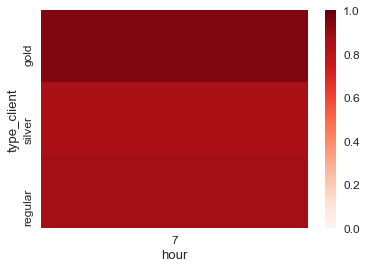

In [29]:
tt = ds.pivot_table(columns=['hour'], index=['type_client'], values='client_missed', aggfunc='mean').reindex(['gold','silver','regular'])
sns.heatmap(tt, vmin=0, vmax=1, cmap='Reds')
del tt
plt.show()

In [30]:
line_loads_ds = get_line_loads(ds, time_to=get_datetime(8,0))

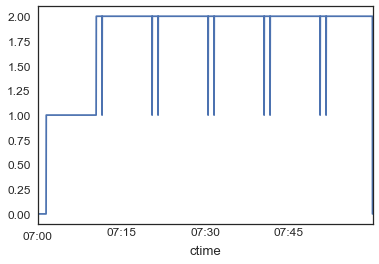

In [31]:
(line_loads_ds>0).sum(1).fillna(0).plot()
plt.show()

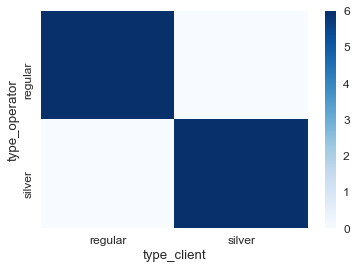

In [32]:
sns.heatmap(ds.pivot_table(index='type_operator', columns='type_client', values='id_connection', aggfunc='count', fill_value=0),
           cmap='Blues')
plt.show()

# Что ещё надо добавить

Сигнал занятости линий

Начальные задержки для каждого звонка

Разные типы звонков

Случайное время готовности ожидания клиента

Случайное время обслуживания для оператора (+поправки на тип оператора) для соединения

Поиск оптимальной комбинации